In [901]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)

from pathlib import Path
import os,sys
import h5py
import sys 

from circus.shared.parser import CircusParser
from circus.shared.files import load_data
import time

import nept
sys.path.append('../PreProcessing/')  
from pre_process_neuralynx import *
from shapely.geometry import Point
from shapely.geometry.polygon import LinearRing, Polygon
from collections import Counter
from descartes import PolygonPatch

In [1177]:
def medFilt(x,window):
    if window%2:
            window=window-1
    win2 = np.int(window/2)
    N=len(x)
    y=np.array(x)
    for ii in np.arange(win2,N-win2+1):
        try:
            idx=(np.arange(-win2,win2)+ii).astype(np.int)
            y[ii] = np.nanmedian(y[idx])
        except:
            pass
    return y

In [1275]:
def medFilt2(x,window):
    if window%2:
            window=window-1
    win2 = np.int(window/2)
    N=len(x)
    y=np.array(x)
    for ii in np.arange(win2,N-win2+1):
        try:
            idx=(np.arange(-win2,win2)+ii).astype(np.int)
            y[ii] = np.nanmedian(y[idx])
        except:
            pass
    for ii in np.arange(N-win2,win2-1,-1):
        try:
            idx=(np.arange(-win2,win2)+ii).astype(np.int)
            y[ii] = np.nanmedian(y[idx])
        except:
            pass
    return y

In [903]:
# path to tracking data
datPath = '/Users/alexgonzalez/Google Drive/PostDoc/Data/T3g/Li/Li_T3g_060418/VT1.nvt'
pos = loadnvt2(datPath)

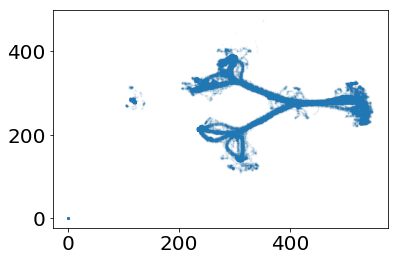

In [907]:
t = pos['time']
x = pos['x']
y = pos['y']
plt.scatter(x,y,1,alpha=0.05)

In [910]:
def RotateXY(x,y,angle):
    x2 = x*np.cos(angle)+y*np.sin(angle)
    y2 = -x*np.sin(angle)+y*np.cos(angle)
    return x2,y2

number of invalid samples = 8493 -> % 0.05375792791766359
number of invalid samples after 2xMedfilt = 0 -> % 0.0
number of invalid samples after smoothing = 0 -> % 0.0


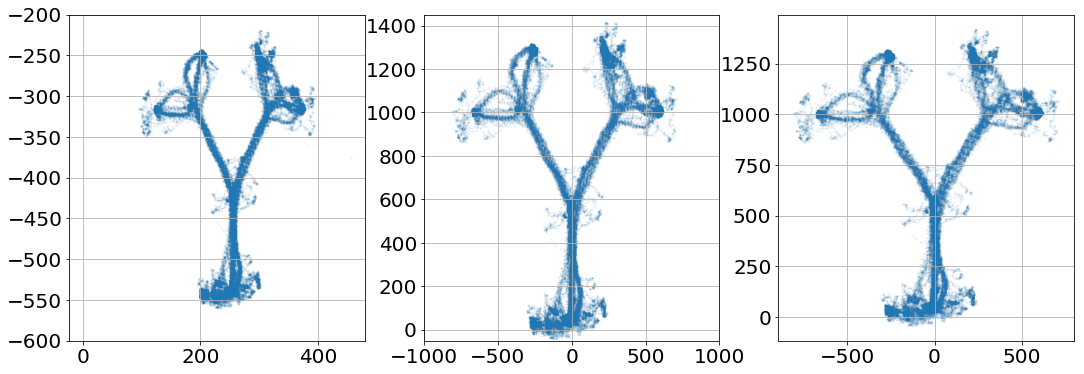

In [1268]:
f,a=plt.subplots(1,3, figsize=(18,6))

rot_ang = np.pi/2+0.05
x_translate = -255
y_translate = 550
y_pix2mm = 1308/305
x_pix2mm = 1358/269
spd_thr=50
#limits in mm space
y_limit = [-100,1500]
x_limit = [-1000,1000]

x2,y2 = RotateXY(x,y,rot_ang)
a[0].scatter(x2,y2,1,alpha=0.05)
a[0].set_ylim(-600,-200)
a[0].grid()

x3 = (x2+x_translate)*x_pix2mm
y3 = (y2+y_translate)*y_pix2mm
a[1].scatter(x3,y3,1,alpha=0.05)
a[1].set_ylim(-50,1450)
a[1].set_xlim(-1000,1000)
a[1].grid()

mask_y = np.logical_or(y3<y_limit[0],y3>y_limit[1])
mask_x = np.logical_or(x3<x_limit[0],x3>x_limit[1])
mask = np.logical_or(mask_y,mask_x)

r=np.sqrt(x3**2+y3**2)
rd=np.append(0,np.diff(r))
mask = np.logical_or(mask,abs(rd)>spd_thr)

xm=np.array(x3)
ym=np.array(y3)    
xm[mask]=np.nan
ym[mask]=np.nan

a[2].scatter(xm,ym,1,alpha=0.05)
a[2].grid()
print('number of invalid samples =' , np.sum(np.isnan([xm])), '-> %', np.mean(np.isnan([xm]) ))

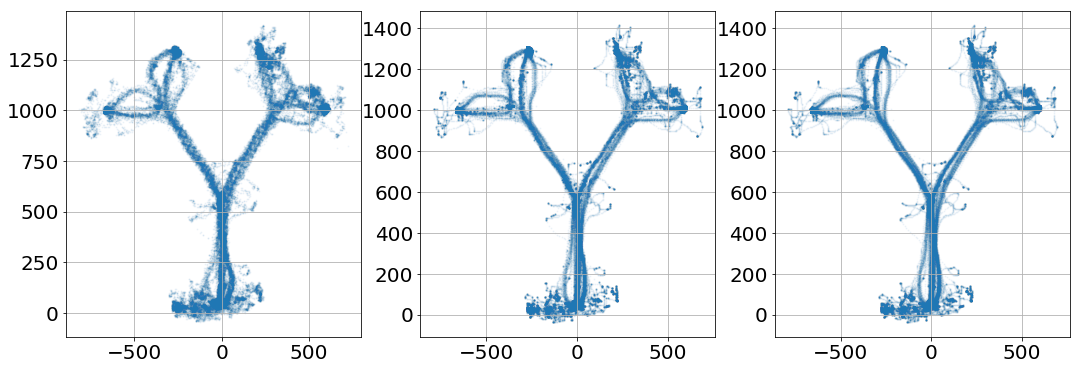

In [1267]:
med_filt_window = 21 # in samples  21samps/60samps/s = 350ms
xm2 = medFilt(medFilt(xm,med_filt_window),med_filt_window)
ym2 = medFilt(medFilt(ym,med_filt_window),med_filt_window)

print('number of invalid samples after 2xMedfilt =' , np.sum(np.isnan([xm2])), '-> %', np.mean(np.isnan([xm2]) ))

badIds = np.where(np.logical_or(np.isnan(xm2), np.isnan(ym2)))
for ii in badIds:
    xm2[ii] = xm2[ii-1]
    ym2[ii] = ym2[ii-1]
    
smooth_filt_window = 15 # in samples 15/6 = 250ms
b = signal.firwin(smooth_filt_window, cutoff = 0.2, window = "hanning")
xm3 = signal.filtfilt(b,1,xm2)
ym3 = signal.filtfilt(b,1,ym2)

print('number of invalid samples after smoothing =' , np.sum(np.isnan([xm3])), '-> %', np.mean(np.isnan([xm3]) ))

f,a=plt.subplots(1,3, figsize=(18,6))

a[0].scatter(xm,ym,1,alpha=0.05)
a[1].scatter(xm2,ym2,1,alpha=0.05)
a[2].scatter(xm3,ym3,1,alpha=0.05)
for i in np.arange(3):
    a[i].grid()
   

In [1277]:
xm4 = medFilt2(xm,med_filt_window)
ym4 = medFilt2(ym,med_filt_window)
xm5 = signal.filtfilt(b,1,xm4)
ym5 = signal.filtfilt(b,1,ym4)

f,a=plt.subplots(1,3, figsize=(18,6))

a[0].scatter(xm,ym,1,alpha=0.05)
a[1].scatter(xm4,ym4,1,alpha=0.05)
a[2].scatter(xm5,ym5,1,alpha=0.05)
for i in np.arange(3):
    a[i].grid()
   

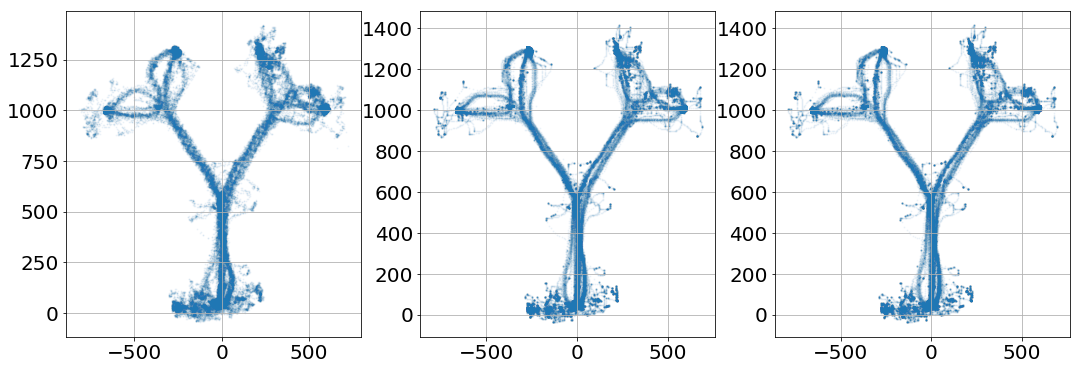

In [1279]:
f,a=plt.subplots(1,3, figsize=(18,6))

a[0].scatter(xm,ym,1,alpha=0.05)
a[1].scatter(xm2,ym2,1,alpha=0.05)
a[2].scatter(xm3,ym3,1,alpha=0.05)
for i in np.arange(3):
    a[i].grid()

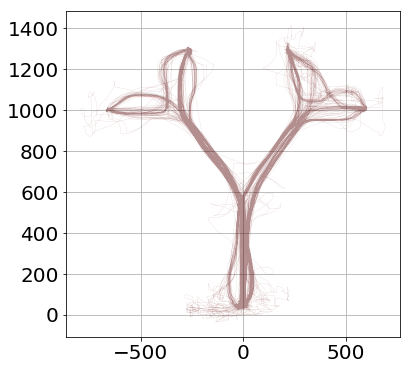

In [1308]:
f,a=plt.subplots(1,1, figsize=(6,6))

a.plot(xm3,ym3,alpha=0.2,color='r',linewidth=0.1)
a.plot(xm5,ym5,alpha=0.3,color='k',linewidth=0.1)

#a.scatter(xm,ym,1,alpha=0.02,color='g')

a.grid()

In [1299]:
def ScaleRotateSmoothTrackDat(x,y):
    #### Static parameters ####
    
    # rotation angle for the maze (for original pixel space)
    rot_ang=np.pi/2+0.05
    
    # y limits in mm space
    y_limit = [-100,1500]
    x_limit = [-1000,1000]
    
    # parameters for translation and scaling
    x_translate = -255
    y_translate = 550

    y_pix2mm = 1308/305
    x_pix2mm = 1358/269
    
    # speed thr
    spd_thr = 50 # mm/frame -> mm/frame*60frames/s*1cm/10mm = 50*6 cm/s
    
    # filtering params
    med_filt_window = 21 # in samples  21samps/60samps/s = 350ms
    smooth_filt_window = 15 # in samples 15/6 = 250ms
    
    ######## Operations ########
    # rotate
    x,y=RotateXY(x,y,rot_ang)
    
    # re-scale
    x = (x+x_translate)*x_pix2mm
    y = (y+y_translate)*y_pix2mm
    
    # compute velocity to create speed threshold
    r=np.append(0,np.sqrt(x**2+y**2))
    rd=np.diff(r)
    mask_r = np.abs(rd)>spd_thr
    
    # mask creating out of bound zones
    mask_y = np.logical_or(y<y_limit[0],y>y_limit[1])
    mask_x = np.logical_or(x<x_limit[0],x>x_limit[1])
    mask = np.logical_or(mask_x,mask_y)
    mask = np.logical_or(mask,mask_r)
    
    x[mask]=np.nan
    y[mask]=np.nan

    # double round of median filters to deal with NaNs
    x = medFilt2(x,med_filt_window)
    y = medFilt2(y,med_filt_window)
    
    # if there are still NaNs assign id to previous value
    badIds = np.where(np.logical_or(np.isnan(x), np.isnan(y)))
    for ii in badIds:
        x[ii] = x[ii-1]
        y[ii] = y[ii-1]
    
    # filter / spatial smoothing
    b = signal.firwin(smooth_filt_window, cutoff = 0.2, window = "hanning")
    x = signal.filtfilt(b,1,x)
    y = signal.filtfilt(b,1,y)
    
    return x,y

xs,ys = ScaleRotateSmoothTrackDat(x,y)

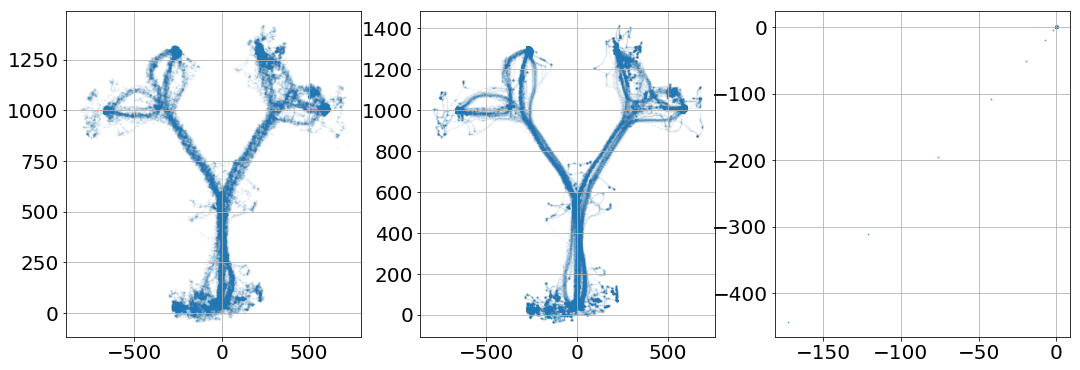

In [1310]:
f,a=plt.subplots(1,3, figsize=(18,6))

a[0].scatter(xm,ym,1,alpha=0.05)
a[0].grid()

a[1].scatter(xs,ys,1,alpha=0.05)
a[1].grid()
a[2].scatter(xs-xm5,ys-ym5,1,alpha=0.5)
a[2].grid()

In [ ]:
def ReSampleDat(t,sig,step=0.02)
    'Nearest neighbor interpolation for resampling.'
    
    tp=np.arange(t[0],t[-1],step)
    sig_ip = interpolate.interp1d(t, sig, kind="nearest",fill_value="extrapolate")

    return sig_ip(tp)

In [1311]:
spz,thz = velocity(xs,ys)

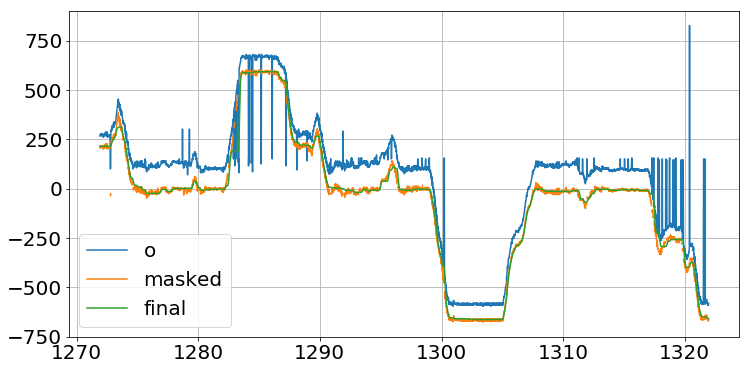

In [1322]:
f,a1=plt.subplots(1,1, figsize=(12,6))
a1.grid() 
window = np.arange(3000)+3000*8

a1.plot(t[window],(y[window]+x_translate)*x_pix2mm)
a1.plot(t[window],xm[window])
a1.plot(t[window],xs[window])
#a1.plot(tp[window],-ys[window])
a1.legend(['o','masked','final'])

In [1324]:
def getPoly(coords):
    return Polygon(coords)
def plotPoly(poly,ax,alpha=0.3):    
    p1x,p1y = poly.exterior.xy
    ax.plot(p1x, p1y, color='k', alpha=alpha,
        linewidth=3,)
    ring_patch = PolygonPatch(poly, fc='b', ec='none', alpha=alpha)
    ax.add_patch(ring_patch)
    #ax.fill(p1x, p1x, alpha=1, fc='r', ec='none')

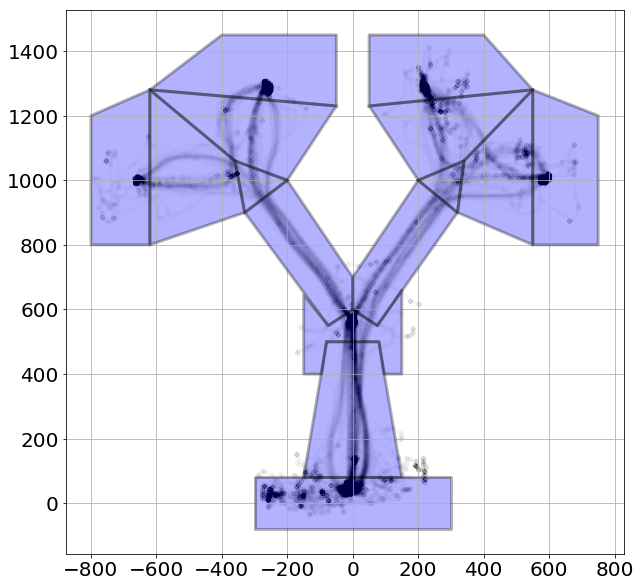

In [1360]:
MazeZonesCoords ={'Home':[(-300, -80), (-300, 80),(300,80),(300, -80)],
                  'Center': [(-80,500),(-95,400),(-150,400),(-150,645),
                             (-75,550),(0,600),(75,550),(150,660),(150,400),(95,400),(80,500)],
                  'SegA': [(-150,80),(-80,500),(80,500),(150,80)],
                  'SegB': [(0,600),(0,700),(200,1000),(320,900),(75, 550)],
                  'SegC': [(340,1060),(550,1280),(550,800),(320,900)],
                  'SegD': [(200,1000),(50,1230),(550,1280),(340,1060)],
                  'SegE': [(0,600),(0,700),(-200,1000),(-330,900),(-75, 550)],
                  'SegF': [(-200,1000),(-50,1230),(-620,1280),(-360,1060)],
                  'SegG': [(-360,1060),(-620,1280),(-620,800),(-330,900)],
                  
                  'G1': [(550,1280),(750,1200),(750,800),(550,800)],
                  'G2': [(50,1230),(50,1450),(400,1450),(550,1280)],
                  'G3': [(-50,1230),(-50,1450),(-400,1450),(-620,1280)],
                  'G4': [(-620,1280),(-800,1200),(-800,800),(-620,800)],
                  
                  'I1': [(200,1000),(340,1060),(320,900)],
                  'I2': [(-330,900),(-360,1060),(-200,1000)],
                 }
MazeZonesGeom = {}
for zo in MazeZonesCoords.keys():
   MazeZonesGeom[zo] = getPoly(MazeZonesCoords[zo])

f,a1=plt.subplots(1,1, figsize=(10,10))
for zo in MazeZonesGeom.keys():
    plotPoly(MazeZonesGeom[zo],a1)
    
a1.plot(xs,ys,alpha=0.1,color='k',linewidth=0.1)
a1.scatter(xs,ys,20, alpha=0.005,color='k')
a1.grid() 


In [1361]:
ZoneOrd=['Home','SegA','Center','SegB','I1','SegC','G1','SegD','G2','SegE','I2','SegF','G3', 'SegG','G4']
Zones = {}
cnt=0
for z in ZoneOrd:
    Zones[z]=ZoneOrd[cnt]
    cnt+=1

nZones = len(ZoneOrd)
PosZones = np.zeros(len(xs),dtype=int)
pcnt = -1

for xp, yp in zip(xs,ys):
    pcnt+=1
    zcnt=0
    outZoneFlag = 0
    if not np.isnan(xp):
        pZoneDist = np.zeros(nZones)
        p = Point(xp,yp)
        for zo in ZoneOrd:
            pZoneDist[zcnt]=MazeZonesGeom[zo].distance(p)
            if MazeZonesGeom[zo].contains(p):
                PosZones[pcnt]=zcnt
                break
            elif zo == ZoneOrd[-1]:
                if np.min(pZoneDist)<20:
                    PosZones[pcnt]=np.argmin(pZoneDist)                   
                else:
                    PosZones[pcnt]=PosZones[pcnt-1]
                break
            zcnt+=1
    else:
        PosZones[pcnt]=PosZones[pcnt-1]
   

In [1362]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
#     for row in M:
#         s = sum(row)
#         if s > 0:
#             row[:] = [f/s for f in row]
    return M

In [1363]:
M = pd.DataFrame(transition_matrix(PosZones),columns=ZoneOrd,index=ZoneOrd)
M

,Home,SegA,Center,SegB,I1,SegC,G1,SegD,G2,SegE,I2,SegF,G3,SegG,G4
Home,46452,158,0,0,0,0,0,0,0,0,0,0,0,0,0
SegA,158,15856,151,0,0,0,0,0,0,0,0,0,0,0,0
Center,0,151,22473,74,0,0,0,0,0,75,0,0,0,0,0
SegB,0,0,80,6516,74,1,0,0,0,3,0,0,0,0,0
I1,0,0,0,75,1808,37,0,58,0,0,0,0,0,0,0
SegC,0,0,0,0,66,5756,56,5,0,0,0,0,0,0,0
G1,0,0,0,0,0,56,7672,0,0,0,0,0,0,0,0
SegD,0,0,0,0,30,33,0,5526,66,0,0,0,0,0,0
G2,0,0,0,0,0,0,0,66,11372,0,0,0,0,0,0
SegE,0,0,69,9,0,0,0,0,0,6019,73,1,0,0,0


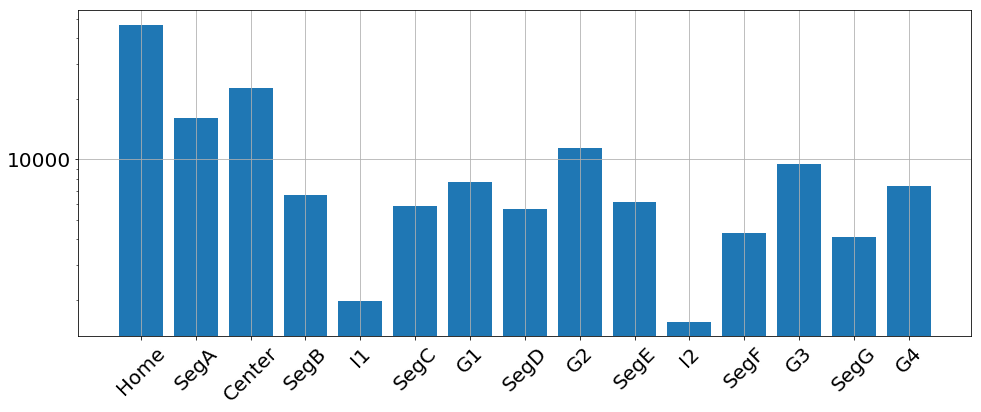

In [1364]:
f,a1=plt.subplots(1,1, figsize=(16,6))
a=Counter(PosZones)
counts,_ = np.histogram(PosZones,np.arange(nZones+1))
zoneIDs = np.arange(nZones)
a1.bar(np.arange(nZones), counts)
a1.set_yscale('log')
#a1.set_yticks([100,200, 500, 1000])
a1.set_xticks(np.arange(len(ZoneOrd)))
a1.set_xticklabels(ZoneOrd)
a1.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
a1.grid()

for tick in a1.get_xticklabels():
    tick.set_rotation(45)


In [1369]:
counts, ids=np.histogram(PosZones,np.arange(nZones+1))
print(len(counts),counts,ids)

15 [46611 16165 22773  6674  1978  5883  7728  5655 11438  6171  1561  4293
  9531  4125  7400] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


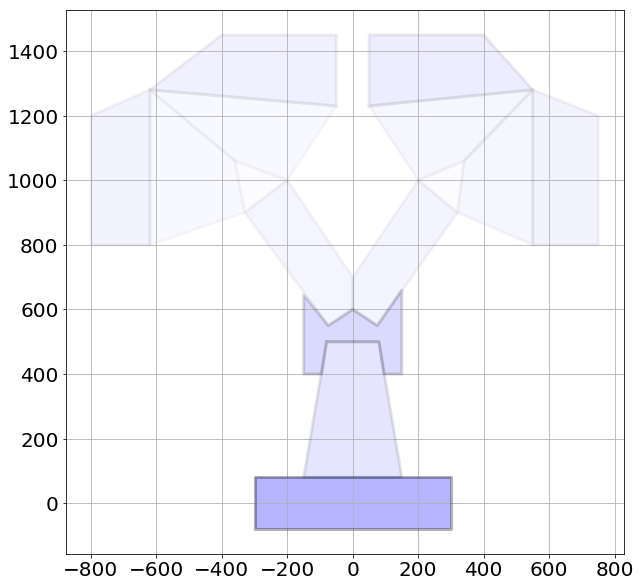

In [1371]:
prob = counts/np.sum(counts)
cnt = 0
f,a1=plt.subplots(1,1, figsize=(10,10))
a1.grid() 

for zo in ZoneOrd:
    plotPoly(MazeZonesGeom[zo],a1,alpha=prob[cnt])
    cnt+=1

In [1372]:
prob = values/np.sum(values)
values

[13879,
 20753,
 5150,
 1991,
 3846,
 6759,
 2432,
 6026,
 40467,
 5379,
 5138,
 3835,
 5676,
 8811,
 1644]

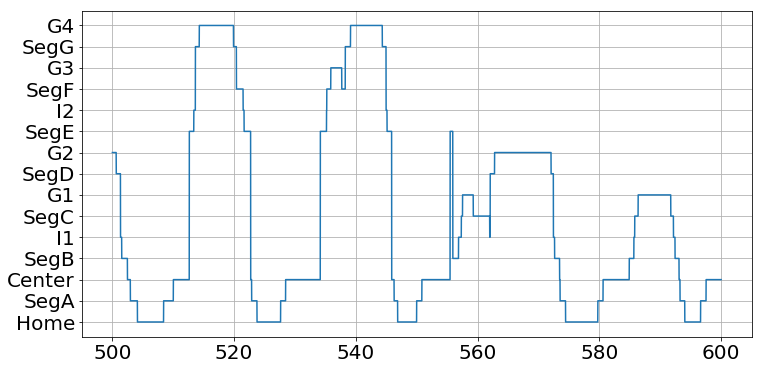

In [1376]:
ZoneOrd=['Home','SegA','Center','SegB','I1','SegC','G1','SegD','G2','SegE','I2','SegF','G3', 'SegG','G4']

f,a1=plt.subplots(1,1, figsize=(12,6))
window = np.arange(5000)+5000*5
a1.plot(tp[window]-tp[0],PosZones[window])
a1.set_yticks(np.arange(len(ZoneOrd)))
a1.set_yticklabels(ZoneOrd)
a1.grid()